In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point, LineString, MultiLineString
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import numpy as np
from pyfonts import load_font
from matplotlib.patches import Patch

In [2]:
subtitle_font = load_font('/home/kbt28/.local/share/fonts/texgyreheros-bold.otf')
subtitle_font.set_size(10)
zone_label_font = load_font('/home/kbt28/.local/share/fonts/texgyreheros-bold.otf')
zone_label_font.set_size(10)
legend_font = load_font('/home/kbt28/.local/share/fonts/texgyreheros-regular.otf')
legend_font.set_size(10)
cbar_font = load_font('/home/kbt28/.local/share/fonts/texgyreheros-regular.otf')
cbar_font.set_size(9)

In [3]:
# load zone gdf and assign COLOR
zone_zipfile = "NYISO_Load_Zone.zip"
zones_gdf = gpd.read_file(zone_zipfile)
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'CAPITL', 'COLOR'] = 1.0 # F
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'CENTRL', 'COLOR'] = 1.0 # C 
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'DUNWOD', 'COLOR'] = 1.0 # I
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'GENESE', 'COLOR'] = 3.0 # B
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'HUD VL', 'COLOR'] = 3.0 # G
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'LONGIL', 'COLOR'] = 2.0 # K
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'MILLWD', 'COLOR'] = 2.0 # H
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'MHK VL', 'COLOR'] = 2.0 # E
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'N.Y.C.', 'COLOR'] = 3.0 # J
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'NORTH', 'COLOR']  = 3.0 # D
zones_gdf.loc[zones_gdf['ZN_ABBRV'] == 'WEST', 'COLOR']   = 2.0 # A

zones_gdf.set_crs(epsg=4326, inplace=True)

zones_val_to_color = {
    1.0: '#a3c6d2',
    2.0: '#c8a2c8',
    3.0: '#b5c9a5'
}
zones_gdf['COLOR'] = zones_gdf['COLOR'].map(zones_val_to_color)
zones_gdf = zones_gdf.dissolve(by="ZN_ABBRV", as_index=False);

In [4]:
renewables_df = pd.DataFrame({
    "zone": ["WEST", "GENESE", "CENTRL", "NORTH", "MHK VL", "CAPITL", "HUD VL", "MILLWD", "DUNWOD", "N.Y.C.", "LONGIL"],
    "label": ["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K"],
    "Solar": [1297+14440, 402+1648, 1098+9006, 0, 1240+5698, 2154+15647, 2270+3353, 202, 299, 1676, 2883+1441],
    "Wind": [2692, 390, 1923, 1935, 1821, 1864, 606, 303, 0, 8250, 121+6488],
    "Hydro": [2460, 0, 0, 909.8, 376.3, 269.6, 0, 0, 0, 0, 0]
})
renewable_types = ["Solar", "Wind", "Hydro"]

zones = zones_gdf.merge(renewables_df, left_on="ZN_ABBRV", right_on="zone")

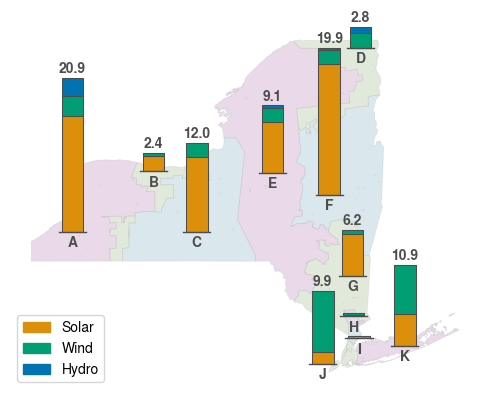

In [5]:
# plot
renewable_colors = ["#dc8f0b", "#019e73", "#0173b2"]

bar_pts = [(-74.25, 42.9), # F
           (-76.7, 42.4), # C
           (-73.7, 40.95), # I
           (-77.5, 43.22), # B
           (-73.82, 41.8), # G
           (-72.85, 40.85), # K
           (-75.3, 43.2), # E
           (-73.8, 41.25), # H
           (-74.37, 40.6), # J
           (-73.67, 44.9), # D
           (-79.0, 42.4), # A
]

fig = plt.figure(figsize=(5.0, 5.0))

ax = fig.add_subplot()
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
zones.plot(ax=ax, color=zones['COLOR'], edgecolor='#c2c2c2', linewidth=0.5, zorder=1, alpha=0.4)
for i, row  in zones.iterrows():
    x, y = bar_pts[i]

    values = [row[type] for type in renewable_types]
    total = sum(values)

    width=0.5
    ax.plot([x - width/2, x + width/2], [y, y], color="#4d4d4d", linewidth=1)

    scale = 0.0001
    bottom = y

    ax.annotate(row.label, xy=(x, y-0.2), xycoords='data', color='#4d4d4d', font=zone_label_font, horizontalalignment='center')
    for val, color in zip(values, renewable_colors):
        bar_height = val*scale
        ax.bar(x, bar_height, width=0.4, bottom=bottom, color=color, edgecolor="#4d4d4d", linewidth=0.75)
        bottom += bar_height
    
    if (row.label != "H") & (row.label != "I"):
        ax.annotate(f"{total / 1000:.1f}", xy=(x, bottom+0.15), xycoords='data', color='#4d4d4d', font=zone_label_font, horizontalalignment='center', verticalalignment='center_baseline')

legend_patches = [Patch(color=c, label=t) for t, c in zip(renewable_types, renewable_colors)]
ax.legend(handles=legend_patches, loc="lower left", prop=legend_font)

ax.axis("off")
plt.tight_layout()
    
plt.savefig(f"map_zonal_caps.png", dpi=300, bbox_inches='tight')